In [1]:
# data analysis
import pandas as pd
# math/stats analysis
import statsmodels.api as sms
import numpy as np
import math
# visuals
import pylab as pl
%pylab inline
# to take care of deprecation warnings and what not
pd.options.mode.chained_assignment = None 
    
# load data
data = pd.read_csv('shots.csv', header = 0)

# distance from basket new column
data['dis_from_basket'] = (data['shot_x']**2 + data['shot_y']**2)**(0.5)

# only want to analyze purposeful C&S and shots, erase the half court heeves so avgs aren't scewed
df = data[data['dis_from_basket'] < 45]
df.index = arange(9723)

# create new categorical variables and convert into 1s and 0s
# Paint: < 10 ft of hoop. Mid-Range: Within 10-22 ft of hoop. 3pt: > 22 ft of hoop.
df['inPaint'] = np.where((df['dis_from_basket'] < 10),1,0)
df['midRange'] = np.where((df['dis_from_basket'] >= 10)&(df['dis_from_basket'] < 22),1,0)
df['threePoint'] = np.where((df['dis_from_basket'] >= 22),1,0)

# for statistical analysis
df['intercept'] = 1.0

Populating the interactive namespace from numpy and matplotlib


In [2]:
# dependent variable
y = df['made']

# eliminate dis_from_basket as I have turned it into a categorical variable, then I must get rid of inPaint
# don't need a third dummy variable, the computer will know it is in the paint

# independent variables
X = df.drop(['made','shot_x','defender_velocity_angle','shooter_velocity_angle','defender_angle','shot_y','shooter_velocity_ft_sec','dis_from_basket','inPaint'], axis = 1)

# logisitic regression
logit = sms.Logit(y, X)
result = logit.fit()

# let's view the p values and remove dependent variables with p values greater than 0.05
result.summary()

Optimization terminated successfully.
         Current function value: 0.640386
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   made   No. Observations:                 9723
Model:                          Logit   Df Residuals:                     9717
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 Jan 2017   Pseudo R-squ.:                 0.05381
Time:                        17:47:07   Log-Likelihood:                -6226.5
converged:                       True   LL-Null:                       -6580.6
                                        LLR p-value:                8.270e-151
============================================================================================
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
dribbles_before             -0.0349      0.006     -6.319      0.000        -0.046    -0.024
defender_distance            0.0910      0.009     10.608      0.000         0.074     0.108
defender_velocity_ft_sec     0.0129      0.006      2.044      0.041         0.001     0.025
midRange                    -0.8245      0.057    -14.568      0.000        -0.935    -0.714
threePoint                  -1.4431      0.059    -24.443      0.000        -1.559    -1.327
intercept                   -0.0615      0.055     -1.109      0.268        -0.170     0.047
============================================================================================
"""

In [3]:
# logisitic  function
def prob_fun(x):
  return (1 / (1 + math.exp(-x)))

# adjusted logistic Regression
# B_0 + B_1*B_sht_y + B_2*B_dribbles_before + ...
df['probs_temp'] = (-.0615 -.0349*df['dribbles_before'] + .0910*df['defender_distance'] + \
                .0129*df['defender_velocity_ft_sec'] - .8245*df['midRange'] - 1.4431*df['threePoint'])
real_probs = []
for i in range(9723):
    real_probs.append(prob_fun(df['probs_temp'][i]))
    
# New column for FG success likelihood for each shot    
df['probs'] = asarray(real_probs).T
df = df.drop(['probs_temp'], axis = 1)
df.head()

,shot_x,shot_y,shooter_velocity_ft_sec,shooter_velocity_angle,dribbles_before,made,defender_distance,defender_angle,defender_velocity_ft_sec,defender_velocity_angle,dis_from_basket,inPaint,midRange,threePoint,intercept,probs
0,-1.643617,18.119135,1.870883,23.618326,1,0,10.004074,33.036907,4.906114,-59.100586,18.193530,0,1,0,1.0,0.513187
1,-4.488024,22.658467,1.001283,133.975882,0,0,7.655019,-13.404524,2.358548,10.362831,23.098668,0,0,1,1.0,0.314844
2,-3.935172,2.132872,10.471914,4.918328,1,0,3.610886,167.802771,2.075523,-22.959020,4.476016,1,0,0,1.0,0.564382
3,21.084429,0.482098,2.230983,-96.206905,1,0,1.113495,-17.560110,3.045782,82.618237,21.089940,0,1,0,1.0,0.314259
4,7.844834,39.231280,12.000000,19.650760,3,0,2.573718,16.306678,6.632319,-119.031511,40.007934,0,0,1,1.0,0.215932


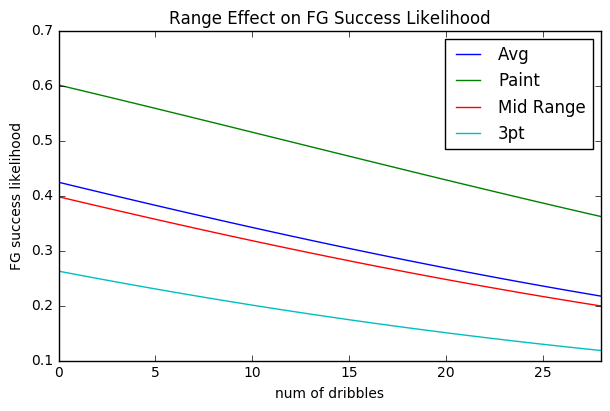

In [4]:
# getting likelihood of success for a particular shot
def get_probs(var,x,y):
    temp = (-.0615 -.0349*var + .0910*df['defender_distance'].mean() + \
                .0129*df['defender_velocity_ft_sec'].mean() - .8245*x - 1.4431*y)
    return prob_fun(temp)
# comparing at different ranges
prob_avg = []; prob_paint = []; prob_mr = []; prob_three = []; lst = []
for i in range(29):
    prob_avg.append(get_probs(i,df['midRange'].mean(),df['threePoint'].mean()))
    prob_paint.append(get_probs(i,0,0))
    prob_mr.append(get_probs(i,1,0))
    prob_three.append(get_probs(i,0,1))
    lst.append(i)
array = asarray([prob_avg, prob_paint, prob_mr, prob_three]).T   
datas = pd.DataFrame(array)
# graoh likelihoods side by side
datas.plot(title = 'Range Effect on FG Success Likelihood')
plt.legend(['Avg','Paint','Mid Range','3pt'])
plt.tight_layout()
plt.xlabel('num of dribbles')
plt.ylabel('FG success likelihood')

In [5]:
df['dis_from_basket_rd'] = df['dis_from_basket'].round()

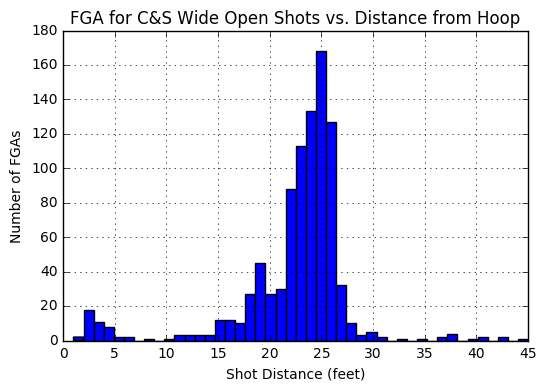

In [6]:
# create new dataframe for C&S shots that are wide open (defender_distance > 7 ft)
wideOpen = df[(df['dribbles_before']==0) & (df['defender_distance'] > 7)]

# graph number of shot attempts that were wide open
wideOpen['dis_from_basket_rd'].hist(bins = 45)
plt.title('FGA for C&S Wide Open Shots vs. Distance from Hoop')
plt.xlabel('Shot Distance (feet)')
plt.ylabel('Number of FGAs')

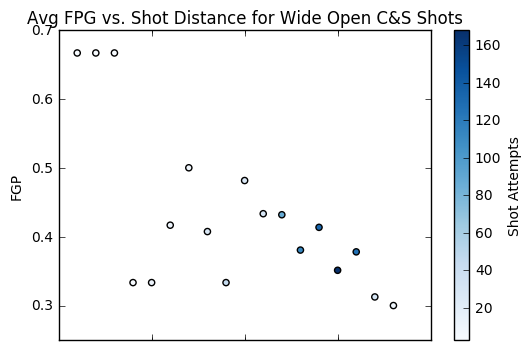

In [7]:
# FGP vs shot distance
disFGPs = []
for i in range(46):
    disFGPs.append(wideOpen[wideOpen['dis_from_basket_rd']==i]['made'].mean())
# these were most common
openFGPs = pd.DataFrame(disFGPs[11:29],columns = ['FGP'])
openFGPs.index = range(11,29)

# getting number of shots taken
shotAttempts = []
for i in range (11, 29):
    shotAttempts.append((wideOpen['dis_from_basket_rd']==i).value_counts()[True])

# transform list to array to add to dataframe
openFGPs['Shot Attempts'] = asarray(shotAttempts).T

openFGPs['Shot Distance'] = openFGPs.index

openFGPs.plot(kind = 'scatter', x = 'Shot Distance', y = 'FGP', c = 'Shot Attempts', cmap = 'Blues')
plt.title('Avg FPG vs. Shot Distance for Wide Open C&S Shots')
plt.xlabel('Shot Distance')

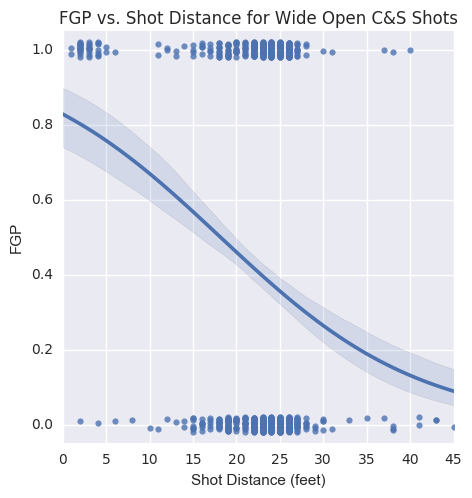

In [8]:
# showing FG success probability as a function of shot distance
import seaborn as sns
g = sns.lmplot(x="dis_from_basket_rd", y="made",data=wideOpen,
                y_jitter=.02, logistic=True)
g.set(xlim=(0, 45), ylim=(-.05, 1.05))
sns.plt.title('FGP vs. Shot Distance for Wide Open C&S Shots')
sns.plt.xlabel('Shot Distance (feet)')
sns.plt.ylabel('FGP')

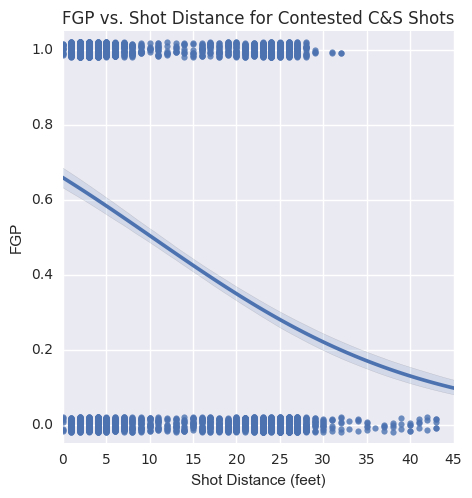

In [9]:
# showing FG success probability as a function of shot distance
notWideOpen = df[(df['dribbles_before']==0) & (df['defender_distance'] <= 7)]
k = sns.lmplot(x="dis_from_basket_rd", y="made",data=notWideOpen,
                y_jitter=.02, logistic=True)
k.set(xlim=(0, 45), ylim=(-.05, 1.05))
sns.plt.title('FGP vs. Shot Distance for Contested C&S Shots')
sns.plt.xlabel('Shot Distance (feet)')
sns.plt.ylabel('FGP')